# Sparse Qarray Tutorial

This tutorial demonstrates the new sparse support in jaxquantum's Qarray implementation. The new implementation uses an architecture based on different implementations (dense and sparse) while maintaining full backward compatibility.

## What is Sparse Support?

Sparse matrices are matrices where most elements are zero. For quantum systems, many operators (like Hamiltonians) have sparse structure, especially for large systems. Sparse representations can offer significant memory and computational advantages when the sparsity is high enough.

## When to Use Sparse vs Dense

- **Use Sparse**: When your matrices have many zeros (sparsity > 70-80%) and you're doing operations like matrix multiplication, addition, or scalar multiplication
- **Use Dense**: For small matrices, when doing operations like matrix exponentials, or when sparsity is low

The new implementation automatically handles fallback from sparse to dense for unsupported operations.


In [8]:
import jaxquantum as jqt
import jax.numpy as jnp
import jax.experimental.sparse as sparse
import numpy as np
import time
import matplotlib.pyplot as plt
from jax import jit, grad, vmap

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)


## 1. Creating Sparse Qarrays

There are several ways to create sparse Qarrays:


In [2]:
# Method 1: Create dense Qarray and convert to sparse
dense_data = jnp.array([[1, 0, 0], [0, 2, 0], [0, 0, 3]])
qarr_dense = jqt.Qarray.create(dense_data)
qarr_sparse = qarr_dense.to_sparse()

print("Dense Qarray:")
print(qarr_dense)
print(f"Is dense: {qarr_dense.is_dense}")
print(f"Is sparse: {qarr_dense.is_sparse}")

print("\nSparse Qarray:")
print(qarr_sparse)
print(f"Is dense: {qarr_sparse.is_dense}")
print(f"Is sparse: {qarr_sparse.is_sparse}")


Dense Qarray:
Quantum array: dims = ((3,), (3,)), bdims = (), shape = (3, 3), type = oper, impl = dense
Qarray data =
[[1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 3.+0.j]]
Is dense: True
Is sparse: False

Sparse Qarray:
Quantum array: dims = ((3,), (3,)), bdims = (), shape = (3, 3), type = oper, impl = sparse
Qarray data =
BCOO(complex128[3, 3], nse=3)
Is dense: False
Is sparse: True


In [3]:
# Method 2: Create sparse Qarray directly
sparse_data = sparse.BCOO.fromdense(jnp.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]))
qarr_from_sparse = jqt.Qarray.from_sparse(sparse_data)

print("From sparse data:")
print(qarr_from_sparse)
print(f"Is sparse: {qarr_from_sparse.is_sparse}")

# Method 3: Create with implementation parameter
qarr_sparse_direct = jqt.Qarray.create(dense_data, implementation="sparse")

print("\nDirect sparse creation:")
print(qarr_sparse_direct)
print(f"Is sparse: {qarr_sparse_direct.is_sparse}")


From sparse data:
Quantum array: dims = ((3,), (3,)), bdims = (), shape = (3, 3), type = oper, impl = sparse
Qarray data =
BCOO(complex128[3, 3], nse=4)
Is sparse: True

Direct sparse creation:
Quantum array: dims = ((3,), (3,)), bdims = (), shape = (3, 3), type = oper, impl = dense
Qarray data =
[[1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 3.+0.j]]
Is sparse: False


In [5]:
jqt.sigmaz().to_sparse() ^ jqt.sigmaz().to_sparse()

Quantum array: dims = ((2, 2), (2, 2)), bdims = (), shape = (4, 4), type = oper, impl = dense
Qarray data =
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]

In [4]:
(jqt.sigmaz().to_sparse() @ jqt.basis(2,0)).to_dense()

Quantum array: dims = ((2,), (1,)), bdims = (), shape = (2, 1), type = ket, impl = dense
Qarray data =
[[1.+0.j]
 [0.+0.j]]

100% |██████████| [00:00<00:00, 306.97%/s]


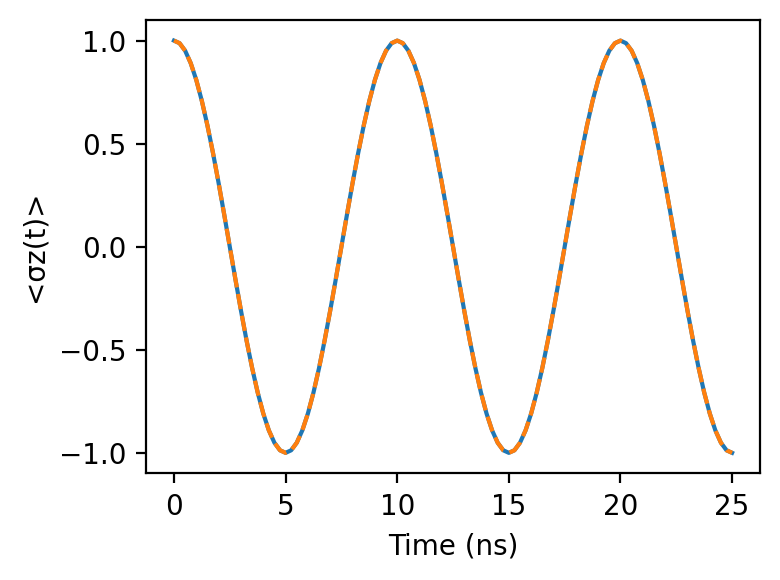

In [9]:
omega_q = 2*jnp.pi*5.0 #GHzz
Omega = 2*jnp.pi*.1
g_state = jqt.basis(2,0) ^ jqt.basis(2,0)
g_state_dm = g_state.to_dm()

ts = jnp.linspace(0,5*jnp.pi/Omega,101)

sz0 = jqt.sigmaz() ^ jqt.identity(N=2)

@jit
def Ht(t):
    H0 = omega_q/2.0*((jqt.sigmaz()^jqt.identity(N=2)) + (jqt.identity(N=2)^jqt.sigmaz()))
    H1 = Omega*jnp.cos((omega_q)*t)*((jqt.sigmax()^jqt.identity(N=2)) + (jqt.identity(N=2)^jqt.sigmax()))
    return H0 + H1

states = jqt.sesolve(Ht, g_state, ts) 
szt = jnp.real(jqt.overlap(states, sz0))

fig, ax = plt.subplots(1, dpi=200, figsize=(4,3))
ax.plot(ts, szt)
ax.plot(ts, jnp.cos(Omega*ts), "--", label=r"$\cos(\Omega t)$")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("<σz(t)>")
fig.tight_layout()

100% |██████████| [00:00<00:00, 15673.78%/s]


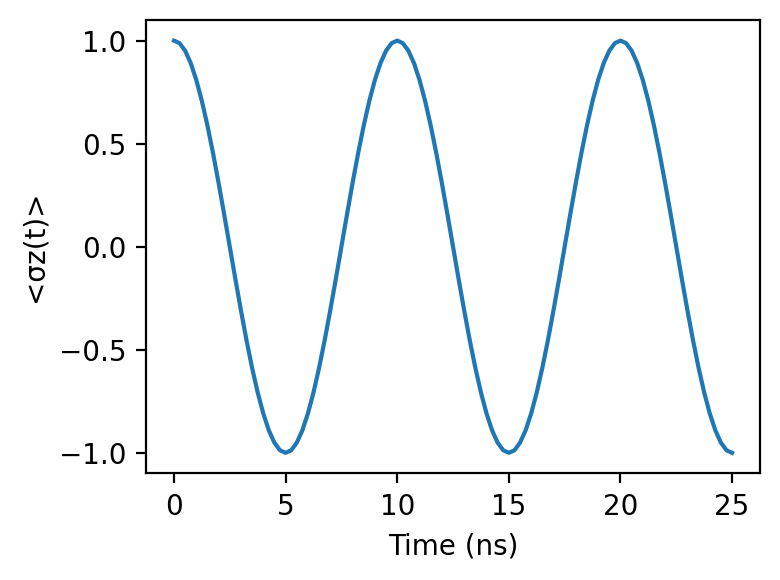

In [1]:
import jaxquantum as jqt
import jax.numpy as jnp
import jax.experimental.sparse as sparse
import numpy as np
import time
import matplotlib.pyplot as plt
from jax import jit, grad, vmap

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)


Omega = 2*jnp.pi*.1
g_state = jqt.basis(2,0) ^ jqt.basis(2,0)
g_state_dm = g_state.to_dm()

ts = jnp.linspace(0,5*jnp.pi/Omega,101)

sz0 = jqt.sigmaz() ^ jqt.identity(N=2)

H0 = Omega*(jqt.sigmax()^jqt.identity(N=2))/2

H0 = H0.to_sparse()

states = jqt.sesolve(H0, g_state, ts) 
szt = jnp.real(jqt.overlap(states, sz0))

fig, ax = plt.subplots(1, dpi=200, figsize=(4,3))
ax.plot(ts, szt)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("<σz(t)>")
fig.tight_layout()

In [4]:
H0.eigenenergies()

Array([-0.31415927, -0.31415927,  0.31415927,  0.31415927], dtype=float64)

In [4]:
jqt.sigmaz() @ jqt.basis(2,0).to_sparse()

Quantum array: dims = ((2,), (1,)), bdims = (), shape = (2, 1), type = ket, impl = dense
Qarray data =
[[1.+0.j]
 [0.+0.j]]

In [12]:
jqt.basis(2,0).to_sparse().frobenius_norm()

Array(1., dtype=float64)